In [93]:
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
from matplotlib import dates
import os


In [83]:
dow = ['SUN', 'MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT']
report_data = pd.DataFrame()
data_path = 'data/'
for file in os.listdir(data_path):
    
    # Check the working folder for csv files
    if file.endswith(".csv"):
        print(file)
        
        # Drop header info, footer info, Rename time column and drop padding
        main_df = pd.read_csv(data_path + file, skipfooter=3, header = 7, engine='python')
        main_df = main_df.rename(columns={"Unnamed: 0": 'Time'})
        main_df['Time'] = pd.to_datetime(main_df['Time'], format="%H:%M").dt.hour
        main_df.drop(main_df.filter(regex='Unnamed').columns, axis = 1, inplace = True)
        
        # Iterate through columns to stack them by day of the week
        data = pd.DataFrame()
        for day in dow:

            df = main_df.iloc[:,0:4].copy()
            df.columns=['Hour', 'Trips', 'North', 'South']
            main_df = main_df.drop(main_df.columns[[1 ,2 ,3]], axis=1).copy()
            df['Weekday']= day
            data = pd.concat([data, df])    
        
        # Add Bridge
        if "Lions Gate" in file:
            data['Bridge'] = "Lion's Gate"
        if 'Second Narrows' in file:
            data['Bridge'] = 'Second Narrows'
        
        # Add Date from filename
        data['Year'] = file[-8:-4]
        
        data.replace(',', '', regex=True, inplace=True)
        data[['Trips', 'North', 'South', 'Year']] = data[['Trips', 'North', 'South', 'Year']].astype(int)
        
        # Save cleaned data for each subset to csv
        if not os.path.exists('clean'):
            os.mkdir('clean')
        data.to_csv(f"clean/{file.replace('.csv', '')}_clean.csv")
        
        # Build working table
        report_data = pd.concat([report_data, data])
report_data

   

AV03P_Lions Gate P-15-1NS - NY2019.csv
AV03P_Lions Gate P-15-1NS - NY2020.csv
AV03P_Lions Gate P-15-1NS - NY2021.csv
AV03P_Second Narrows P-15-2EW - NY2019.csv
AV03P_Second Narrows P-15-2EW - NY2020.csv
AV03P_Second Narrows P-15-2EW - NY2021.csv


,Hour,Trips,North,South,Weekday,Bridge,Year
0,0,1139,679,459,SUN,Lion's Gate,2019
1,1,755,441,314,SUN,Lion's Gate,2019
2,2,505,284,220,SUN,Lion's Gate,2019
3,3,376,208,167,SUN,Lion's Gate,2019
4,4,267,128,138,SUN,Lion's Gate,2019
...,...,...,...,...,...,...,...
19,19,4615,2683,1932,SAT,Second Narrows,2021
20,20,3670,2124,1546,SAT,Second Narrows,2021
21,21,3163,1812,1351,SAT,Second Narrows,2021
22,22,2574,1470,1103,SAT,Second Narrows,2021


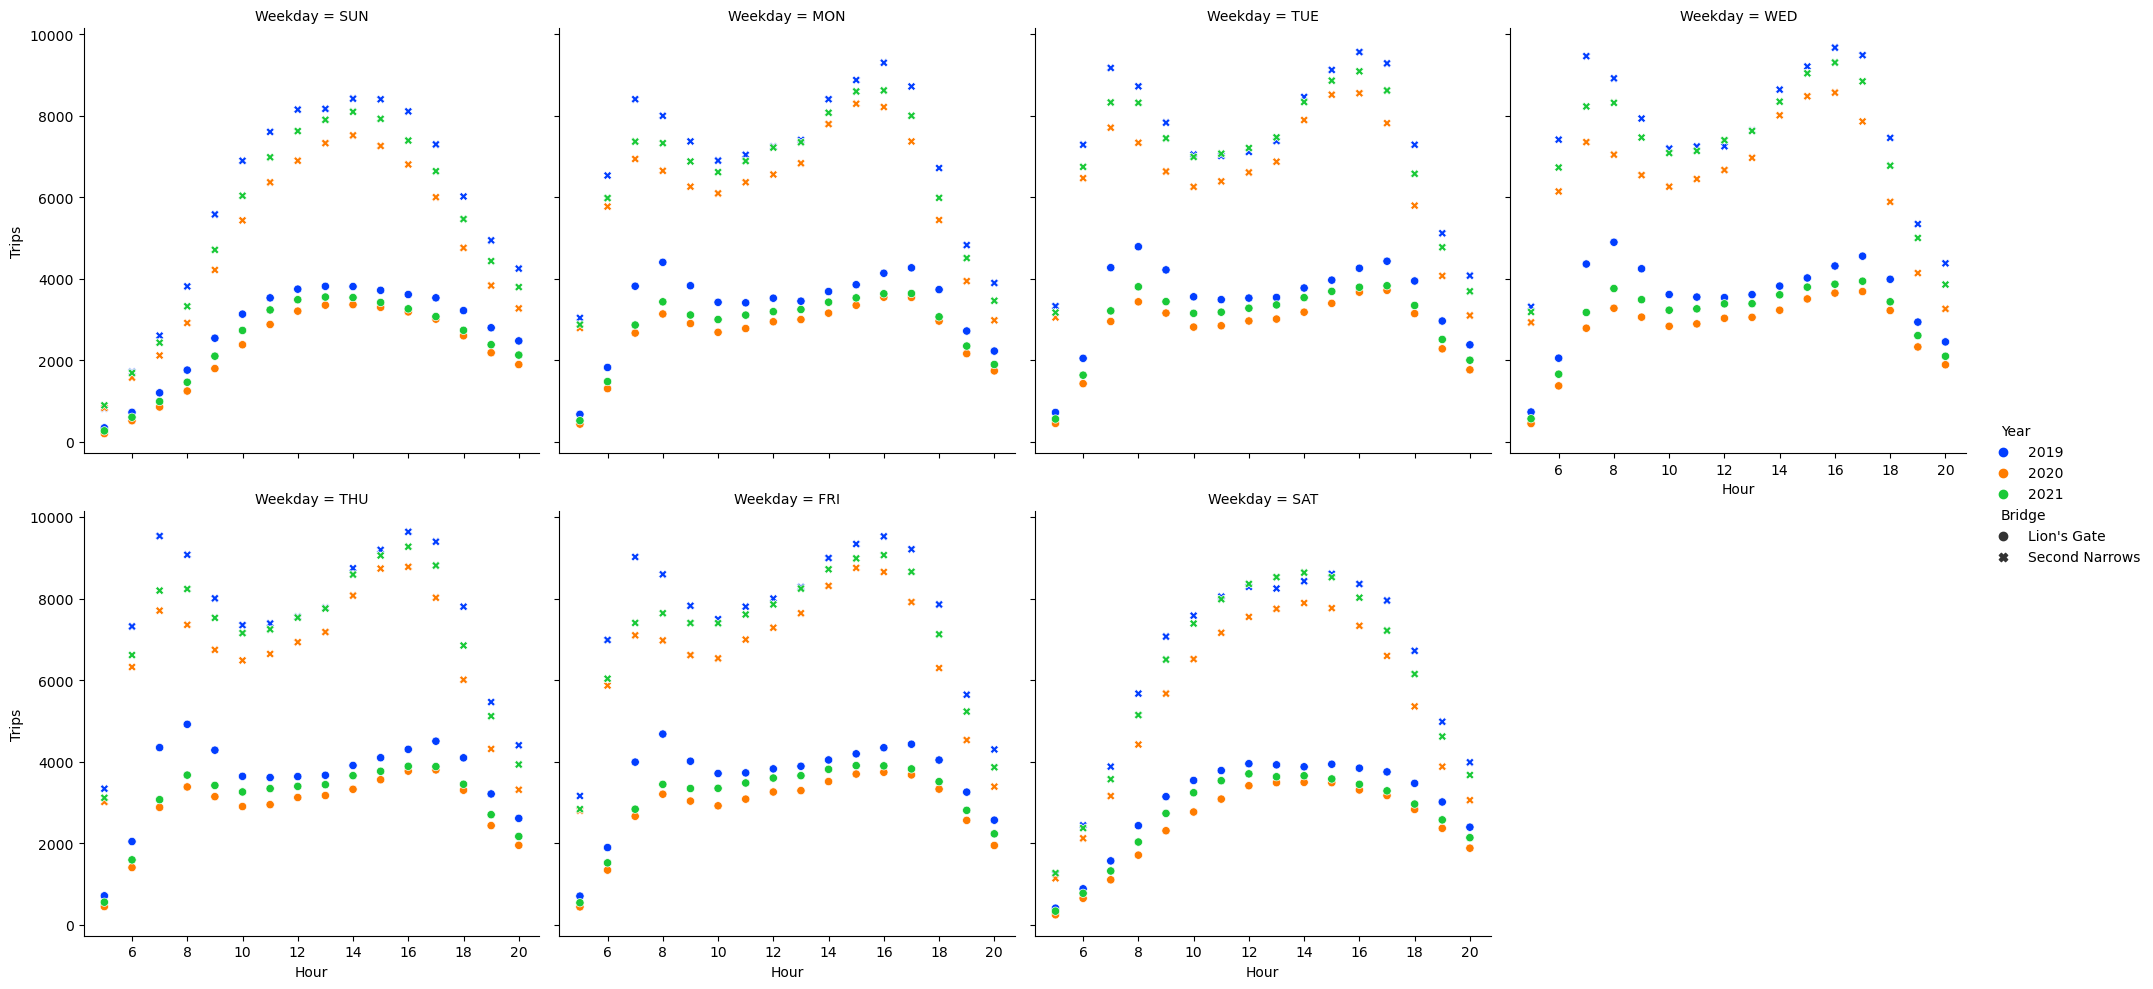

In [84]:
#for year in report_data['Year'].unique():
#    plt.figure()
#    sns.catplot(x='Hour', y='Trips', data=report_data[report_data.Year == year], hue='Bridge', col='Weekday');
report_data = report_data[report_data['Hour'].between(5, 20)]
sns.relplot(x='Hour', y='Trips', data=report_data, hue='Year', col='Weekday', palette='bright', style='Bridge', col_wrap=4);
plt.savefig('Weekly.png')

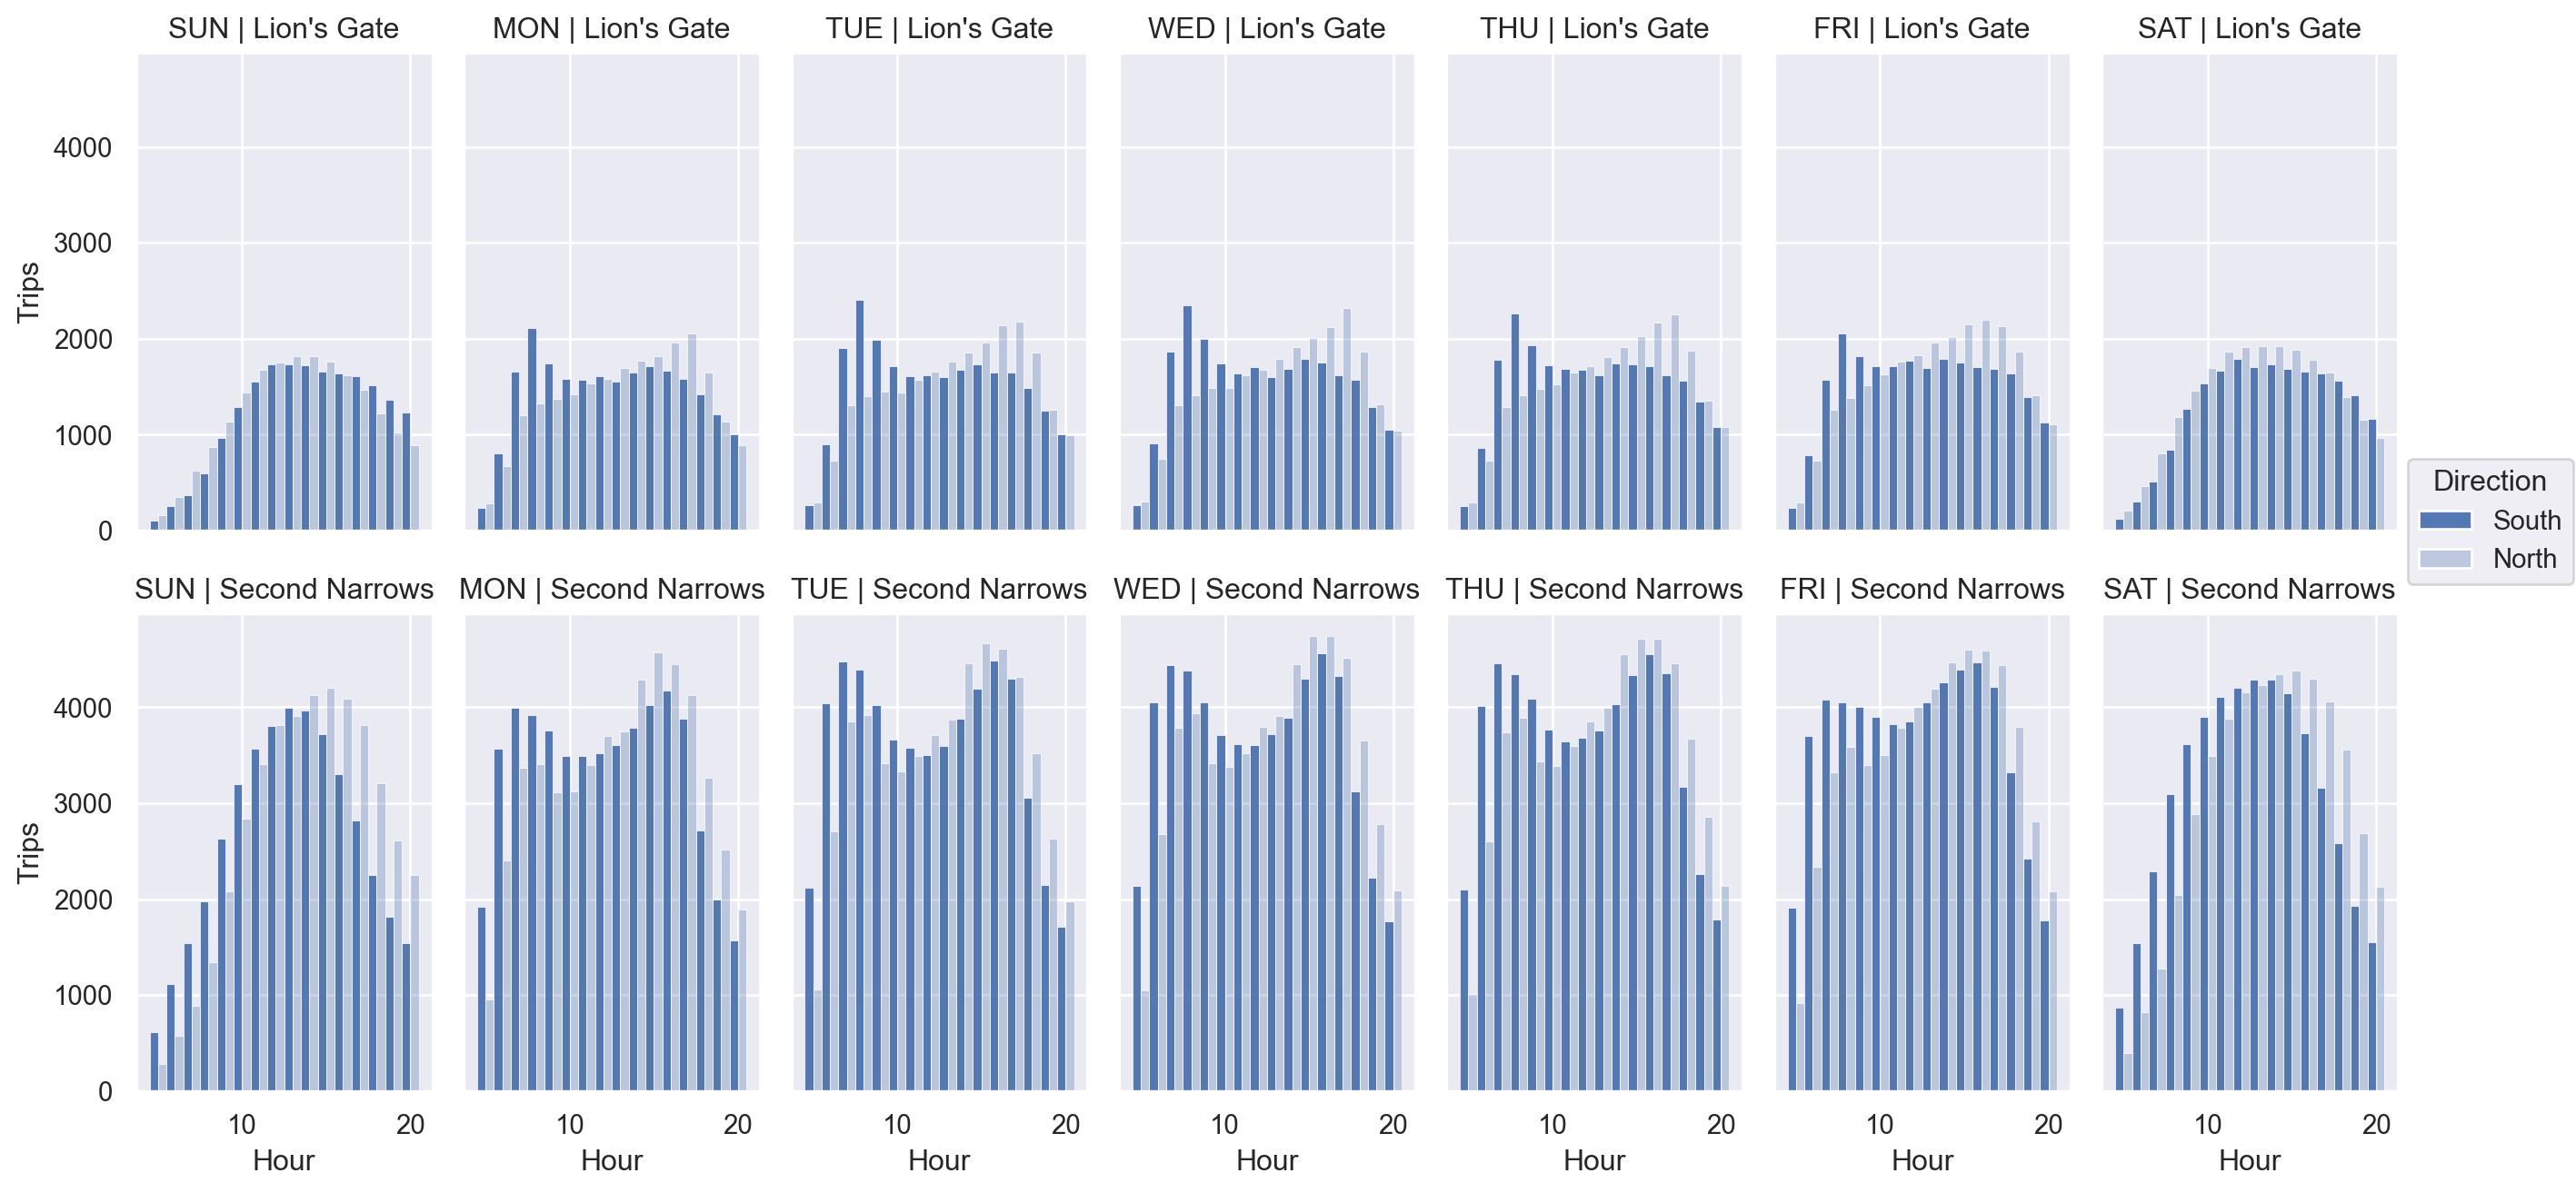

In [121]:
latest_dir = report_data[['Hour', 'South', 'North', 'Weekday', 'Bridge', 'Year']]
latest_dir = latest_dir.query('Year==2021')
latest_dir = latest_dir.melt(['Hour', 'Weekday', 'Bridge', 'Year'], var_name='Direction', value_name='Trips')

# This is not the actual saved asset, because there is a rough edge in the new seaborn Plot objects that cuts off the legend, so in the blog post it is a screenshot.
so.Plot(latest_dir, x='Hour', y='Trips', alpha='Direction').facet(col='Weekday', row='Bridge').add(so.Bars(), so.Dodge()).layout(size=(14, 7)).save('Direction.png')


In [123]:
latest_dir

,Hour,Weekday,Bridge,Year,Direction,Trips
0,5,SUN,Lion's Gate,2021,South,104
1,6,SUN,Lion's Gate,2021,South,252
2,7,SUN,Lion's Gate,2021,South,367
3,8,SUN,Lion's Gate,2021,South,593
4,9,SUN,Lion's Gate,2021,South,966
...,...,...,...,...,...,...
443,16,SAT,Second Narrows,2021,North,4292
444,17,SAT,Second Narrows,2021,North,4055
445,18,SAT,Second Narrows,2021,North,3561
446,19,SAT,Second Narrows,2021,North,2683


In [148]:
rate = latest_dir

def calc_rate(row):
    if row['Bridge'] == 'Lion\'s Gate':

        if row['Direction'] == 'South':

            if 6 <= row['Hour'] <= 9:
                return row['Trips'] / 2

            else:
                return row['Trips']

        if row['Direction'] == 'North':

            if 6 <= row['Hour'] <= 9:
                return row['Trips']

            else:
                return row['Trips'] / 2

    # Second Narrows
    else:
        return row['Trips'] / 3


rate['Rate'] = rate.apply(lambda  row: calc_rate(row), axis=1)

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    display(rate)

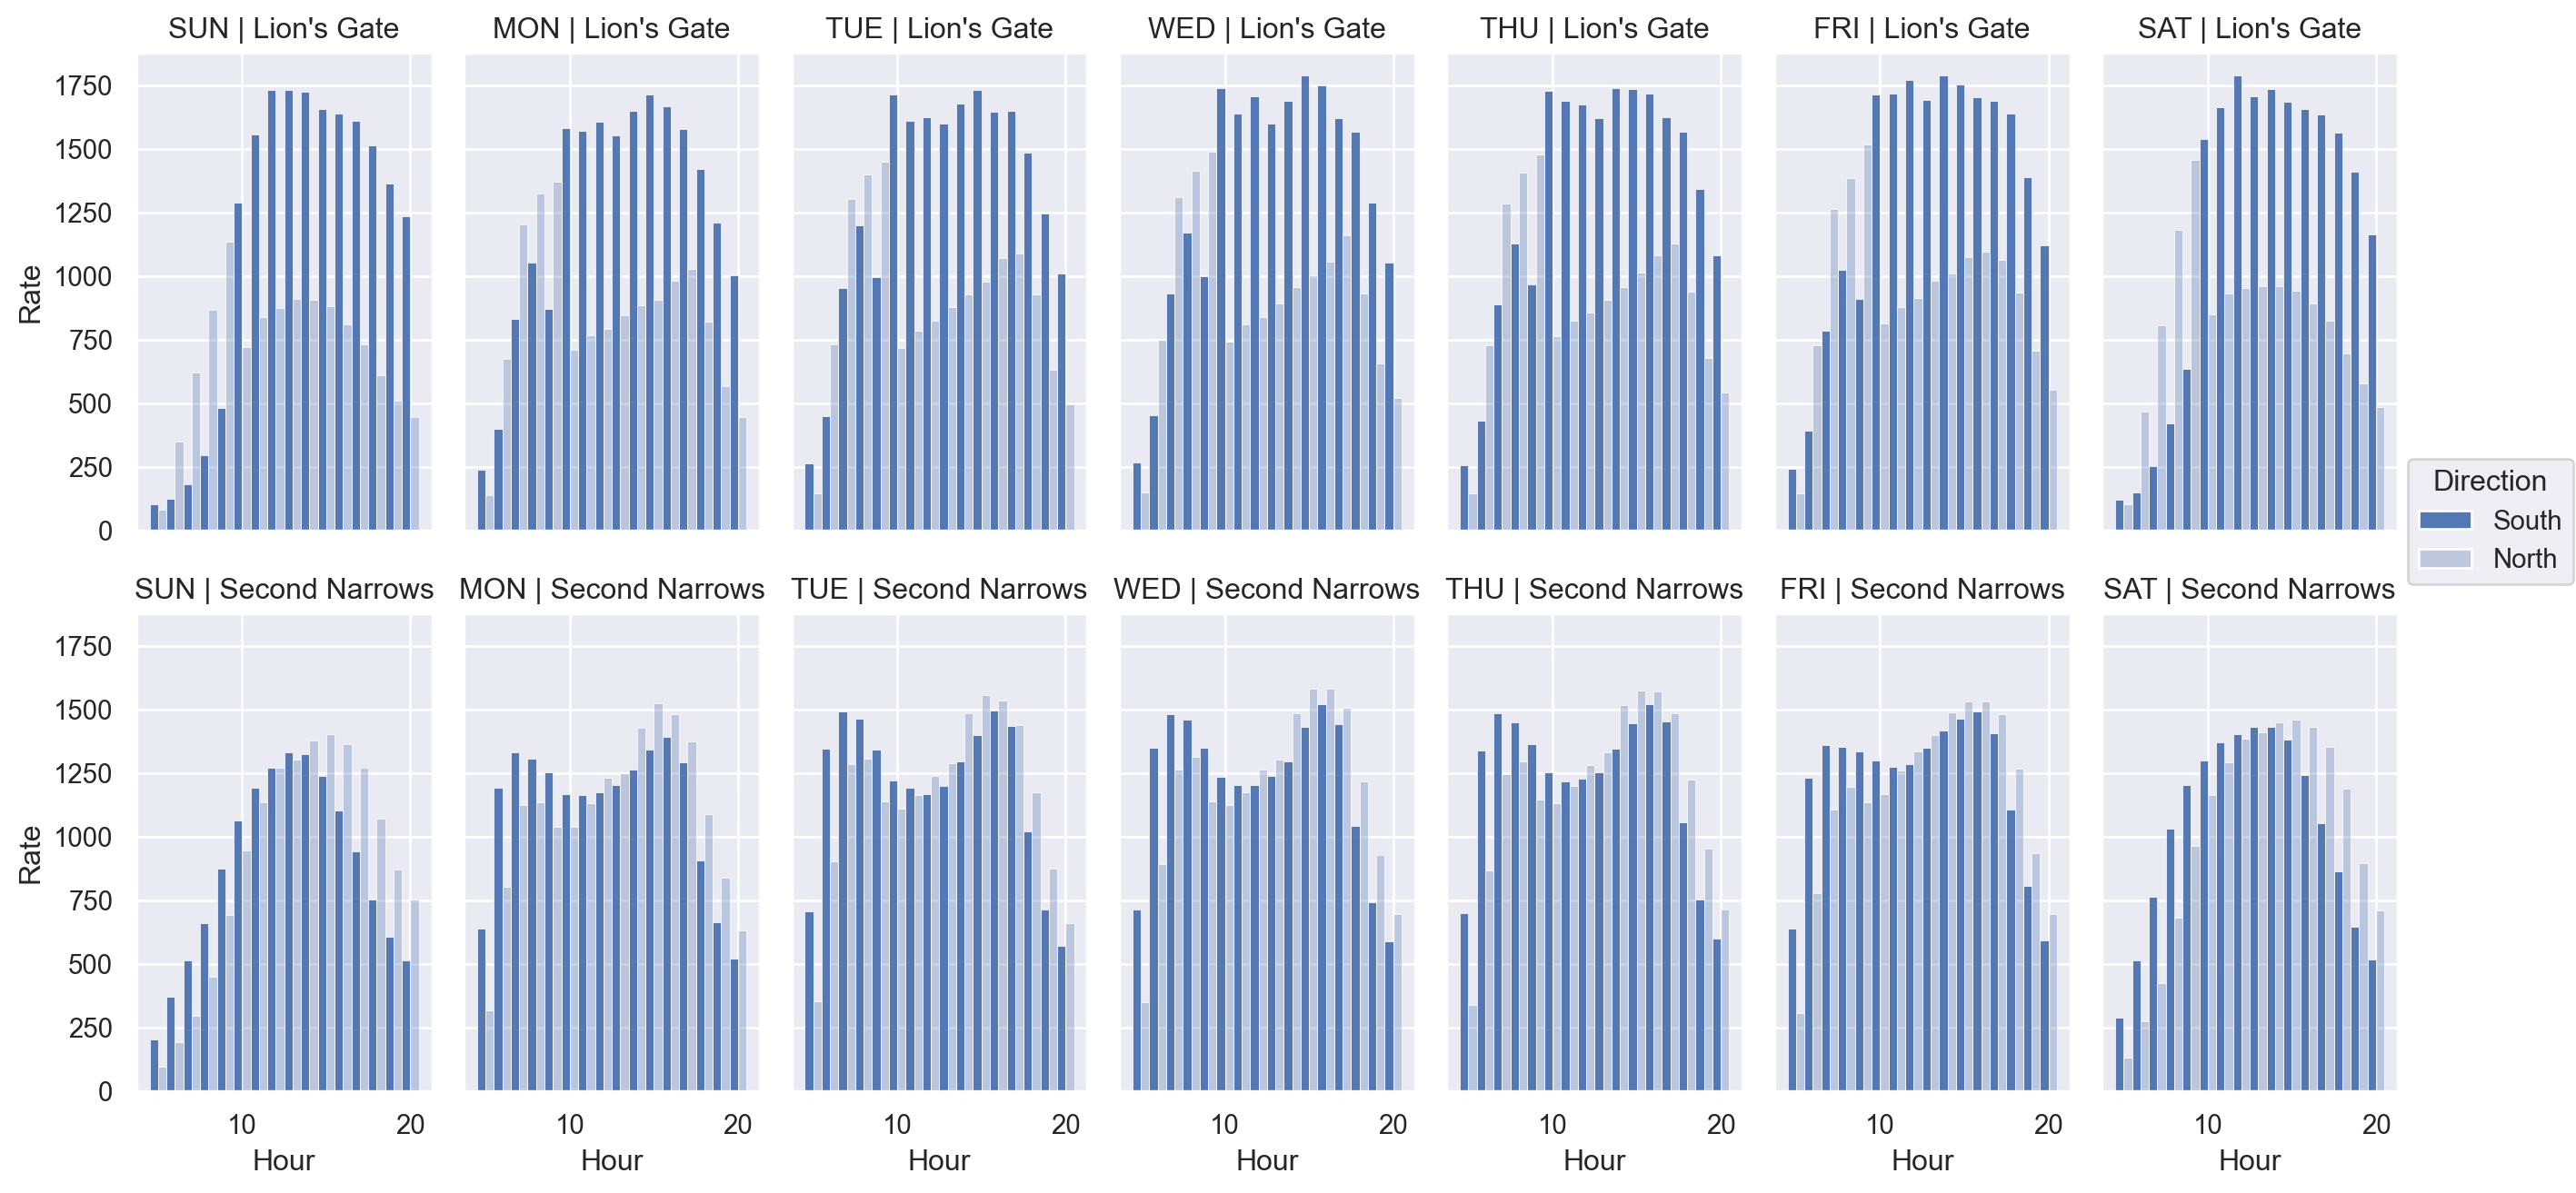

In [149]:
# This is not the actual saved asset, because there is a rough edge in the new seaborn Plot objects that cuts off the legend, so in the blog post it is a screenshot.
so.Plot(rate, x='Hour', y='Rate', alpha='Direction').facet(col='Weekday', row='Bridge').add(so.Bars(), so.Dodge()).layout(size=(14, 7)).save('Rate.png')

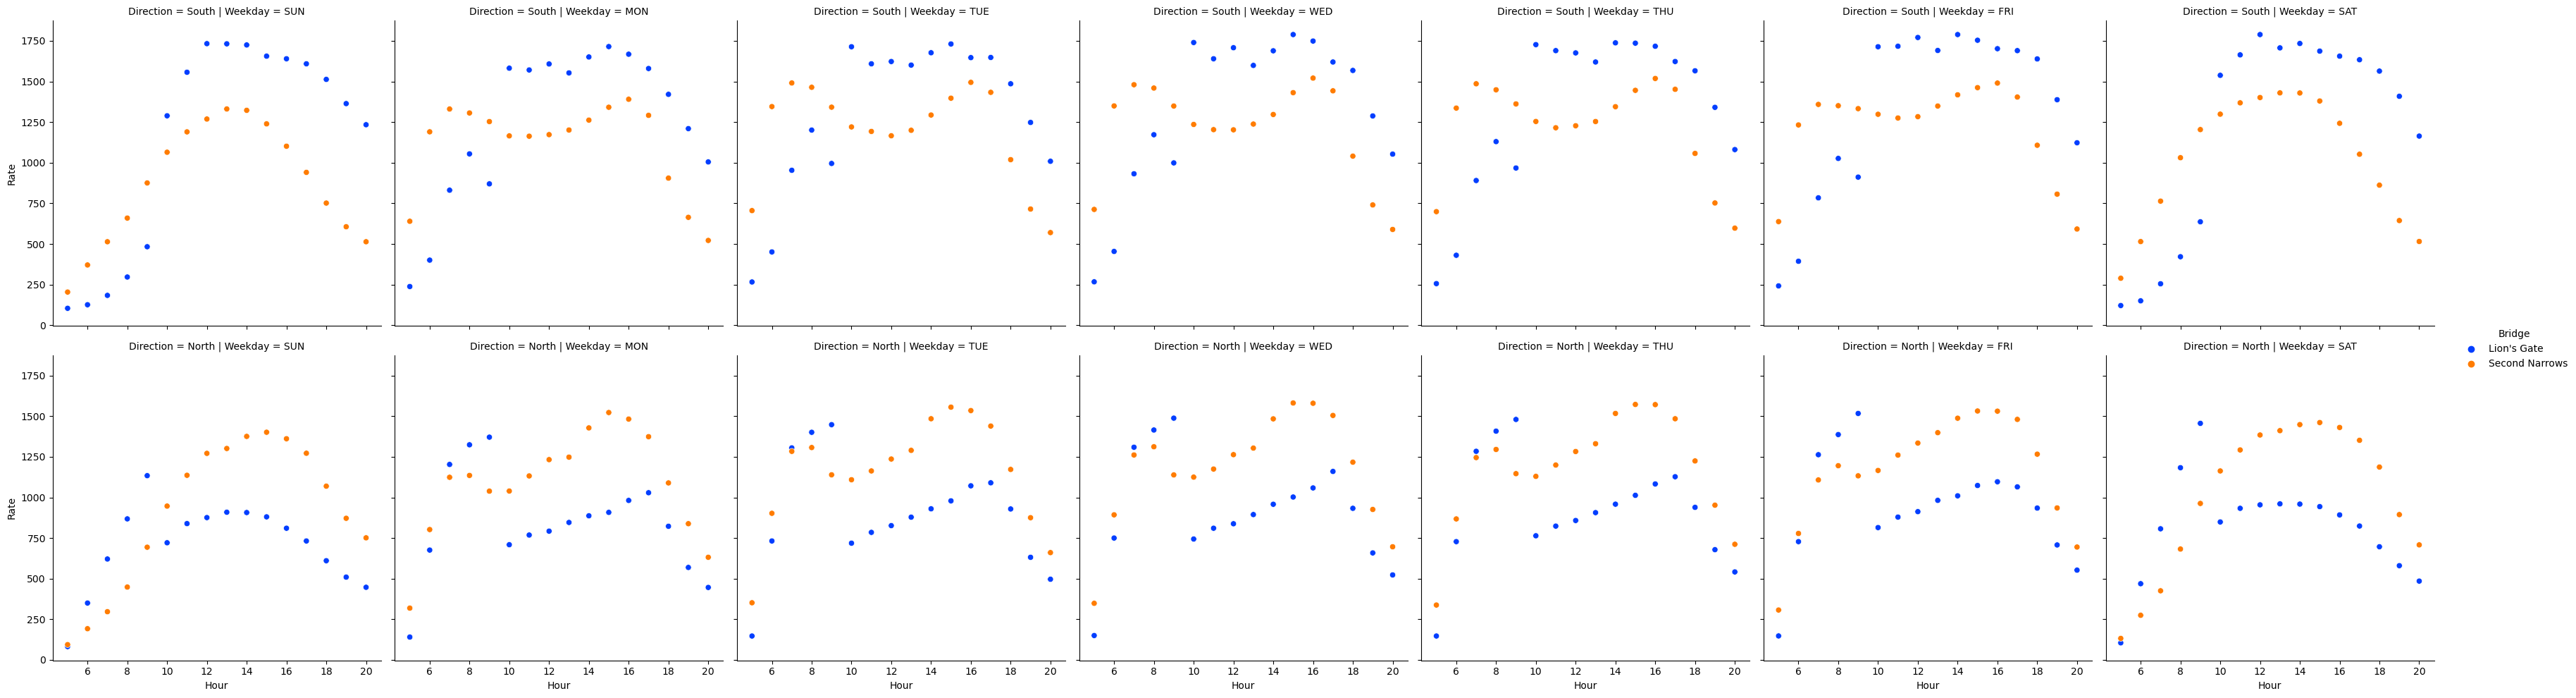

In [157]:
sns.relplot(x='Hour', y='Rate', data=rate, col='Weekday', palette='bright', hue='Bridge', row='Direction')
plt.savefig('Rate_Compare.png')